## SMS Spam Detection Using LSTM RNN

### Introduction

- Recurrent Neural Network (RNN) allows previous outputs to be used as inputs while having hidden states.

- Long short-term memory (LSTM) is a type of artificial RNN which can learn learns longer-term temporal dependencies.

### Source of Data

https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged according being ham (legitimate) or sp

## Project Goal

To detect spam from SMS text messages.

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wordcloud

In [3]:
df = pd.read_csv("SMSSpamCollection.txt", sep="\t", header=None, names=["label", "sms"])

In [211]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [148]:
df.shape

(5572, 2)

In [4]:
df.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.groupby("label").describe()

sms                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

The dataset contains 4825 ham and 747 spam messages.

In [7]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

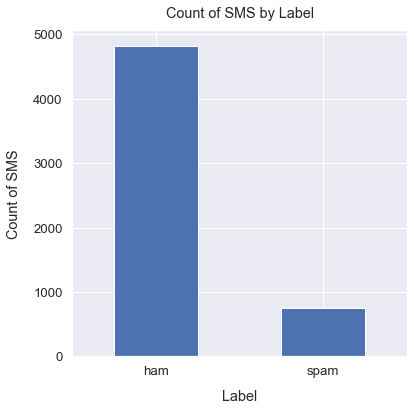

In [8]:
sns.set(font_scale=1.2)
df['label'].value_counts().plot(kind='bar', figsize=(6, 6), rot=0)
plt.xlabel("Label", labelpad=12)
plt.ylabel("Count of SMS", labelpad=12)
plt.title("Count of SMS by Label", y=1.02);

In [229]:
df['sms']= df['sms'].str.lower()
df.head()

,label,sms
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [230]:
df['length'] = df['sms'].apply(len)

In [214]:
df.head()

,label,sms,length
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61


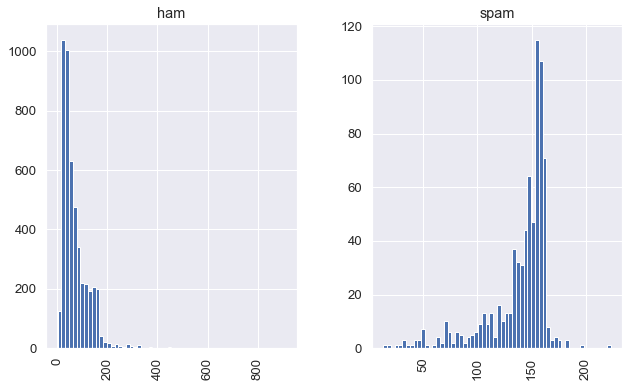

In [215]:
df.hist(column='length', by='label', bins=60, figsize=(10,6));

In [231]:
# Replace ham with 0 and spam with 1
df = df.replace(['ham','spam'],[0, 1])

In [220]:
df.head()

,label,sms,length
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
3,0,u dun say so early hor... u c already then say...,49
4,0,"nah i don't think he goes to usf, he lives aro...",61


In [232]:
df_ham  = df[df['label'] == 0].copy()
df_spam = df[df['label'] == 1].copy()

In [233]:
df_ham.head(3)

,label,sms,length
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
3,0,u dun say so early hor... u c already then say...,49


In [234]:
df_spam.head(3)

,label,sms,length
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
5,1,freemsg hey there darling it's been 3 week's n...,147
8,1,winner!! as a valued network customer you have...,157


### Wordcloud

In [235]:
import wordcloud

def show_wordcloud(df_spam_or_ham, title):
    text = ' '.join(df_spam_or_ham['sms'].astype(str).tolist())
   
    stopwords = ["will", "it"] + list(wordcloud.STOPWORDS)        
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,6), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=18 )
    plt.show()

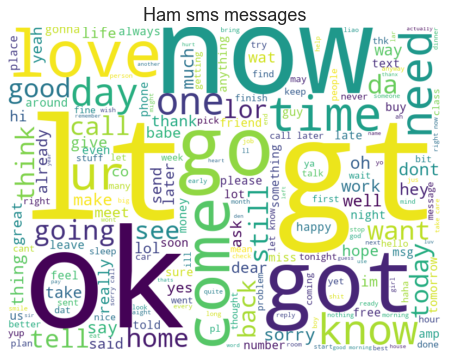

In [236]:
show_wordcloud(df_ham, "Ham sms messages")

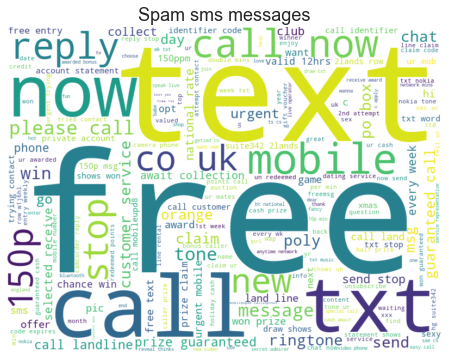

In [237]:
show_wordcloud(df_spam, "Spam sms messages")

In [30]:
df['target'] = df['label'].map( {'spam':1, 'ham':0 })
df.head(5)

,label,sms,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Separate train and test data

In [62]:
## Split Training and Test data
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(4458, 3) (1114, 3)


### Create y-data for analysis

In [63]:
y_train = df_train['target'].values
y_test = df_test['target'].values
y_test.shape

(1114,)

### Create x-data for analysis

In [64]:
X_train = df_train['sms'].values
X_test = df_test['sms'].values
X_test.shape

(1114,)

### Tokenize
Use Keras tokenizer API to fit the train data and create a dictionary of words. Word_dict is a list, ordered by the most frequent words.

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_dict = tokenizer.index_word

In [160]:
print(len(word_dict))

7939


In [157]:
for key in sorted(word_dict)[:10]:
    print(key, word_dict[key])

1 i
2 to
3 you
4 a
5 the
6 u
7 and
8 in
9 is
10 me


### Create sequences from sentences
Use text_to_sequences() function to to split text into a list of words. It puts the index-numbers from word_dict in the place of the words in the train and test data

In [39]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(X_train_seq[:5])
print(df_train.iloc[0,:])
for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

[[667, 2, 233, 93, 640, 40, 132, 9, 51, 1252, 3, 51, 571, 2, 3825, 1020, 3826, 2597, 26, 189, 1427, 2, 1253, 69, 50, 85, 2, 3827], [1, 2016, 123, 404, 20, 157, 6, 3828, 19, 484, 1, 169, 322, 376, 6, 668, 170, 2017], [405, 74, 164, 4, 266, 15, 11, 2018], [51, 147, 2598, 30, 5, 938, 3829, 1121, 22, 12, 641, 71, 3830, 12, 356, 71, 3831, 2, 2599, 274, 938, 606, 12, 36, 154, 2019, 118, 260, 65, 185, 642, 377], [31, 3, 104, 1, 27, 808, 45, 43, 8, 4, 118]]
label                                                  spam
sms       Welcome to UK-mobile-date this msg is FREE giv...
target                                                    1
Name: 4460, dtype: object
welcome to uk mobile date this msg is free giving you free calling to 08719839835 future mgs billed at 150p daily to cancel send go stop to 89123 

### Create pads with fix length
pad_sequence takes a list of sequences as an input and will return a list of padded sequences with the same length. Maximum length is 20.

In [72]:
from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=20, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=20, padding='post')
X_train_pad[:5]
X_train_pad.shape

(4458, 20)

### Create Keras-model
"Long Short Term Memory" (LSTM) is used

In [55]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

length_pads = 20

vocab_size = len(tokenizer.index_word) + 1

lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=length_pads))

# Recurrent layer
lstm_model.add(LSTM(400, dropout=0.1, recurrent_dropout=0.1))

# Output layer
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 20)            158800    
_________________________________________________________________
lstm_8 (LSTM)                (None, 400)               673600    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 401       
Total params: 832,801
Trainable params: 832,801
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [56]:
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, 
                        validation_data=(X_test_pad, y_test))

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 9s 2ms/step - loss: 0.2165 - acc: 0.9249 - val_loss: 0.1004 - val_acc: 0.9641
Epoch 2/10
4458/4458 [==============================] - 7s 2ms/step - loss: 0.0365 - acc: 0.9908 - val_loss: 0.0904 - val_acc: 0.9722
Epoch 3/10
4458/4458 [==============================] - 7s 1ms/step - loss: 0.0185 - acc: 0.9955 - val_loss: 0.1428 - val_acc: 0.9704
Epoch 4/10
4458/4458 [==============================] - 7s 2ms/step - loss: 0.0110 - acc: 0.9978 - val_loss: 0.1108 - val_acc: 0.9722
Epoch 5/10
4458/4458 [==============================] - 7s 2ms/step - loss: 0.0067 - acc: 0.9987 - val_loss: 0.1559 - val_acc: 0.9695
Epoch 6/10
4458/4458 [==============================] - 7s 1ms/step - loss: 0.0105 - acc: 0.9978 - val_loss: 0.1463 - val_acc: 0.9713
Epoch 7/10
4458/4458 [==============================] - 7s 1ms/step - loss: 8.2687e-04 - acc: 1.0000 - val_loss: 0.2193 - val_acc: 0.9695
Epoch 8/10

In [69]:
lstm_model.evaluate(X_test_pad, y_test)

1114/1114 [==============================] - 1s 518us/step


[0.10611620644037235, 0.9757630162649994]

In [71]:
predictions = lstm_model.predict(X_test_pad, verbose=0)
print(predictions[:, 0])

[5.1814318e-03 1.7583370e-06 2.6890635e-04 ... 5.6922436e-06 3.6162498e-06
 5.2432506e-06]


### Test-Estimation

In [57]:
sms_test = ['Hi John, would you come around tonight']
sms_seq = tokenizer.texts_to_sequences(sms_test)

sms_pad = pad_sequences(sms_seq, maxlen=20, padding='post')
tokenizer.index_word
sms_pad
lstm_model.predict_classes(sms_pad)

array([[0]], dtype=int32)

classified the text as not spam correctly

In [58]:
sms_test = ['Free entry in a wkly comp to win NBA final']
sms_seq = tokenizer.texts_to_sequences(sms_test)

sms_pad = pad_sequences(sms_seq, maxlen=20, padding='post')
tokenizer.index_word
sms_pad
lstm_model.predict_classes(sms_pad)

array([[1]], dtype=int32)

classified the text as spam correctly

In [59]:
sms_test = ['Free SMS service for anyone']
sms_seq = tokenizer.texts_to_sequences(sms_test)

sms_pad = pad_sequences(sms_seq, maxlen=20, padding='post')
tokenizer.index_word
sms_pad
lstm_model.predict_classes(sms_pad)

array([[1]], dtype=int32)

classified the text as spam correctly